# **Fine-tuning BERT model to Predict Customer Reviews**

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Set the root path directory
root_path = "/content/drive/MyDrive/LLM"

In [ ]:
# Load the CSV file from Google Drive
df = pd.read_csv("/content/drive/MyDrive/LLM/yelp.csv")

# Display the first few rows of the data
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


# Exploratory Data Analysis (EDA) for target variable (stars)

In [ ]:
# Define the classes list
classes = [f"{i}-Star" for i in range(1, 6)]

# Print the classes list
print(classes)

['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']


In [ ]:
# Define a dictionary to map star ratings
star_mapping = {1: "1-Star", 2: "2-Star", 3: "3-Star", 4: "4-Star", 5: "5-Star"}

# Apply the mapping using the map function
df['stars_class'] = df['stars'].map(star_mapping)

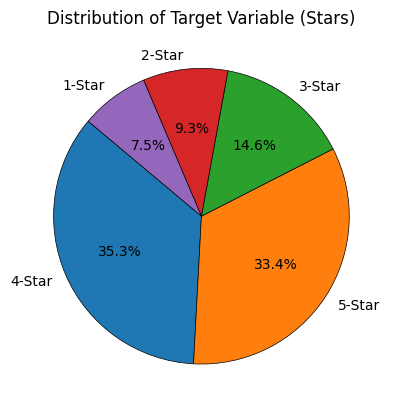

In [ ]:
# Calculate the frequency of each star class
stars = df['stars_class'].value_counts()

# Create a pie chart
plt.pie(stars, labels=stars.index, autopct='%1.1f%%', startangle=140,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0.5,
                      'antialiased': True})
plt.title('Distribution of Target Variable (Stars)')
plt.savefig('pie_chart.png', dpi=300)
plt.show()

# Data Preprocessing

In [ ]:
# Select the input and target column from data
df = df[['text','stars']]
df.head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


In [ ]:
# Define a function to clean the "text" column
def clean_txt(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters, punctuation, and non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

    # Convert text to lowercase
    text = text.lower()

    return text

In [ ]:
# Clean the "text" column using the clean_text function
df["text"] = df["text"].apply(clean_txt)
df.head()

,text,stars
0,my wife took me here on my birthday for breakf...,5
1,i have no idea why some people give bad review...,5
2,love the gyro plate rice is so good and i also...,4
3,rosie dakota and i love chaparral dog park its...,5
4,general manager scott petello is a good egg no...,5


In [ ]:
# See the unique value of stars
unique_stars = df['stars'].unique()
unique_stars.sort()
print(unique_stars)

[1 2 3 4 5]


**Note:** Need to make the customer stars starting from 0 instead of 1 to avoid the CUDA runtime error (59) : device-side assert triggered

In [ ]:
# Define a dictionary to map star ratings to new values
star_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Apply the mapping using the map function
df["stars"] = df["stars"].map(star_mapping)

In [ ]:
# See the data after mapping new star values
df.head()

,text,stars
0,my wife took me here on my birthday for breakf...,4
1,i have no idea why some people give bad review...,4
2,love the gyro plate rice is so good and i also...,3
3,rosie dakota and i love chaparral dog park its...,4
4,general manager scott petello is a good egg no...,4


In [ ]:
# See the unique value of stars after mapping to new values
unique_stars_after_mapping = df['stars'].unique()
unique_stars_after_mapping.sort()
print(f"unique_stars_after_mapping: {unique_stars_after_mapping}")

unique_stars_after_mapping: [0 1 2 3 4]


# Load the pre-trained BERT model and tokenizer

In [ ]:
# Load the pre-trained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move the model to the CUDA device for GPU acceleration
model = model.to('cuda')

# Sample text to see how token IDs are created wrt tokens

In [ ]:
# sample data
text_sample = ["I am Student", "I am currently studying MSc data Science"]

# Tokenize the sample data
tokenized_data = tokenizer(text_sample, padding=True, truncation=True, max_length=512)

# To get tokens of sample data
tokens = tokenizer.tokenize(text_sample)

# Convert tokens to token IDs
token_IDs = tokenizer.convert_tokens_to_ids(tokens)

# Print the sentence, tokens, and token IDs
print(f'\033[1mSample text:\033[0m {text_sample}')
print(f'\033[1mTokens:\033[0m {tokens}')
print(f'\033[1mToken IDs:\033[0m {token_IDs}')

Sample text: ['I am Student', 'I am currently studying MSc data Science']
Tokens: ['i', 'am', 'student', 'i', 'am', 'currently', 'studying', 'msc', 'data', 'science']
Token IDs: [1045, 2572, 3076, 1045, 2572, 2747, 5702, 23794, 2951, 2671]


In [ ]:
# Encoding for the sample text
encoding = tokenizer.encode_plus(text_sample, truncation=True,
                                 add_special_tokens=True,
                                 padding=True, return_attention_mask=True,
                                 return_tensors='pt')

# Print the keys in the encoding dictionary, input ids and tokens corresponding to input IDs
print(f"\033[1mEncoding keys:\033[0m {encoding.keys()}")
print(f"\033[1mEncoding tensors:\033[0m {encoding['input_ids'][0]}")
print(f"\033[1mattention_mask:\033[0m {encoding['attention_mask'][0]}")
print(f"\033[1mTokens:\033[0m {tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])}")

Encoding keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Encoding tensors: tensor([  101,  1045,  2572,  3076,   102,  1045,  2572,  2747,  5702, 23794,
         2951,  2671,   102])
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Tokens: ['[CLS]', 'i', 'am', 'student', '[SEP]', 'i', 'am', 'currently', 'studying', 'msc', 'data', 'science', '[SEP]']


# Train, Validation and Test Split

In [ ]:
# Convert the input and traget variable to list
X = df.text.to_list()
Y = df.stars.to_list()

train_text, temp_text, train_labels, temp_labels = train_test_split(X, Y,
                                                                    random_state=42,
                                                                    test_size=0.3)

# temp_text and temp_labels are used to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=42,
                                                                test_size=0.3)

print("\033[1mLength of training set:\033[0m", len(train_text))
print("\033[1mLength of validation set:\033[0m", len(val_text))
print("\033[1mLength of testing set:\033[0m", len(test_text))

Length of training set: 7000
Length of validation set: 2100
Length of testing set: 900


In [ ]:
# Tokenizing the train, velidation and test data
df_train_tokenized = tokenizer(train_text, padding=True, truncation=True, max_length=512)
df_val_tokenized = tokenizer(val_text, padding=True, truncation=True, max_length=512)
df_test_tokenized = tokenizer(test_text, padding=True, truncation=True, max_length=512)

In [ ]:
# Define a class and function to convert the tokenized output into dataset format
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        item = {key: torch.tensor(value[index]) for key, value in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[index])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
# Create torch datasets for training, validation and testing
train_dataset = CustomDataset(df_train_tokenized, train_labels)
val_dataset = CustomDataset(df_val_tokenized, val_labels)
test_dataset = CustomDataset(df_test_tokenized, test_labels)

In [ ]:
# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    return metric.compute(predictions=predictions, references=labels)

## Fine-tuning BERT model for Custom dataset

In [ ]:
# Define the Training arguments
training_arguments = TrainingArguments(output_dir="./results",            # Output directory
                                       num_train_epochs=10,               # Number of training epochs
                                       learning_rate=1e-5,                # Learning rate
                                       per_device_train_batch_size=16,    # Batch size per device during training
                                       per_device_eval_batch_size=16,     # Batch size for evaluation
                                       weight_decay=0.01,                 # Define weight decay
                                       evaluation_strategy="epoch",       # Evaluate at each epoch
                                       fp16=True,                         # To make training fast
                                       save_strategy="epoch",             # Save strategy
                                       load_best_model_at_end=True        # To load best model
                                       )

In [ ]:
# Define a data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Instantiate the AdamW optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the trainer with the defined TrainingArguments
trainer = Trainer(model=model, args=training_arguments, train_dataset=train_dataset,
                  eval_dataset=val_dataset, data_collator=data_collator,
                  compute_metrics=compute_metrics, tokenizer=tokenizer)

# Train the model

In [ ]:
# Do the training
history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.916777,0.597619
2,1.140200,0.907734,0.584286
3,0.843800,0.936382,0.593810
4,0.673700,0.990698,0.599048
5,0.537200,1.064835,0.593810
6,0.423700,1.172501,0.591429
7,0.321600,1.292376,0.582381
8,0.246000,1.366451,0.580476
9,0.246000,1.404604,0.590952
10,0.207200,1.425326,0.585238


# Evalute the model

In [ ]:
# Evaluate the trained model
eval_results = trainer.evaluate()

In [ ]:
print(f" Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

 Perplexity: 2.48


# Predictions on test dataset

In [ ]:
# Make a prediction on test dataset
test_pred = trainer.predict(test_dataset).predictions

# Predict labels
predicted_labels = np.argmax(test_pred, axis=1)

# True labels for test dataset
true_labels = test_labels
true_labels = np.array(true_labels)

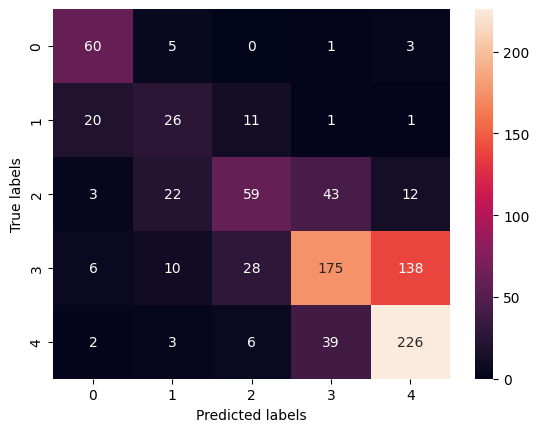

In [ ]:
# Plot the confusion matrix for test results
confusion_matrix_array = confusion_matrix(true_labels, predicted_labels)
confusion_matrix_df = pd.DataFrame(confusion_matrix_array)
sns.heatmap(confusion_matrix_df, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

## Save fine-turned BERT model

In [ ]:
trainer.save_model(root_path)
tokenizer.save_pretrained(root_path)

('/content/drive/MyDrive/LLM/tokenizer_config.json',
 '/content/drive/MyDrive/LLM/special_tokens_map.json',
 '/content/drive/MyDrive/LLM/vocab.txt',
 '/content/drive/MyDrive/LLM/added_tokens.json',
 '/content/drive/MyDrive/LLM/tokenizer.json')

# Checking the model for the given input text

In [ ]:
# Define the function to predict the output for given text
def Input_Text(input_text):
  inputs = tokenizer(input_text,padding = True, truncation = True, return_tensors='pt').to('cuda')
  outputs = model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits)
  predictions = predictions.cpu().detach().numpy()
  return print(f"\033[1mInput Text\033[0m: {input_text}"), print(f"\033[1mPredicted Review\033[0m: {classes[np.argmax(predictions)]}")

Example-1

In [ ]:
Input_Text("I could share photos seamlessly with this app")

Input Text: I could share photos seamlessly with this app
Predicted Review: 5-Star


(None, None)

In [ ]:
Input_Text("I could share photos seamlessly with this app, but the UI could be better")

Input Text: I could share photos seamlessly with this app, but the UI could be better
Predicted Review: 3-Star


(None, None)

Example-2

In [ ]:
Input_Text("Camera of the phone is excellent")

Input Text: Camera of the phone is excellent
Predicted Review: 5-Star


(None, None)

In [ ]:
Input_Text("Camera of the phone is good, but its reslotion is poor")

Input Text: Camera of the phone is good, but its reslotion is poor
Predicted Review: 3-Star


(None, None)

Example-3

In [ ]:
Input_Text("The hotel's rooms are nice")

Input Text: The hotel's rooms are nice
Predicted Review: 4-Star


(None, None)

In [ ]:
Input_Text("The hotel's rooms are very nice, but they could be improved")

Input Text: The hotel's rooms are very nice, but they could be improved
Predicted Review: 3-Star


(None, None)

Example-4

In [ ]:
Input_Text("The look and performance of washing machine is awesome")

Input Text: The look and performance of washing machine is awesome
Predicted Review: 5-Star


(None, None)

In [ ]:
Input_Text("The look and performance of washing machine is awesome, but machine is very heavy")

Input Text: The look and performance of washing machine is awesome, but machine is very heavy
Predicted Review: 3-Star


(None, None)

Example-5

In [ ]:
Input_Text("It is dirty place.. Not recommend to visit it")

Input Text: It is dirty place.. Not recommend to visit it
Predicted Review: 1-Star


(None, None)